#####  Case Business Analyst  

#### Import Libraries 

In [3831]:
import math
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# Preprocessing Data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Under Sampling or OverSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Models 
import xgboost as xgb
from sklearn import tree
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import silhouette_score

## Select Best Features
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, LogisticRegression

## Fine Tuning
from  sklearn.model_selection import GridSearchCV

#### Read csv file

In [3832]:
data_marketing = pd.read_csv("ml_project1_data.csv")

In [3833]:
data_marketing.shape
data_marketing.Response.value_counts()

0    1906
1     334
Name: Response, dtype: int64

In [3834]:
data_marketing_copy = data_marketing.copy()

###  Preprocessing Data  

#### Replace Missing Values 

 - Column "Income" with 34 empty values
 - Used median to fill missing values. It was chosen because there are some outliers in data that can add some bias to central metrics and no complex techniques are necessary for low quantity of missing values

In [3835]:
data_marketing_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
ID                     2240 non-null int64
Year_Birth             2240 non-null int64
Education              2240 non-null object
Marital_Status         2240 non-null object
Income                 2216 non-null float64
Kidhome                2240 non-null int64
Teenhome               2240 non-null int64
Dt_Customer            2240 non-null object
Recency                2240 non-null int64
MntWines               2240 non-null int64
MntFruits              2240 non-null int64
MntMeatProducts        2240 non-null int64
MntFishProducts        2240 non-null int64
MntSweetProducts       2240 non-null int64
MntGoldProds           2240 non-null int64
NumDealsPurchases      2240 non-null int64
NumWebPurchases        2240 non-null int64
NumCatalogPurchases    2240 non-null int64
NumStorePurchases      2240 non-null int64
NumWebVisitsMonth      2240 non-null int64
AcceptedCmp3           2240 

In [3836]:
data_marketing_copy.Income.fillna(data_marketing_copy.Income.median(), inplace=True)

#### Delete features with unique value

- Column "Z_CostContact" and "Z_Revenue" have just 1 unique value and are deleted

In [3837]:
one_value_features = data_marketing_copy.nunique() == 1
one_value_features[one_value_features]

Z_CostContact    True
Z_Revenue        True
dtype: bool

In [3838]:
data_marketing_copy = data_marketing_copy[one_value_features[~one_value_features].index]

#### Fix innappropriate values for somes columns

- Column "Marital Status" has values ['Alone', 'Absurd', 'YOLO', 'Together'] as innapropriate values to marital status. The   rows with "Absurd" and "Yolo" were deleted. The rows with "Together" was aggregate with "Married" and turned "Married/Together". The "Marital Status" with "Alone" were classified as "Single".
- Column "Education" has values of levels of education. As a feature that the level important the values "Master" and "2n Cycle" can be considered as same level to this problem.
- Column "Year_Birth" has Year birth impossible. So theses rows  will be deleated

In [3839]:
data_marketing.Marital_Status.value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [3840]:
data_marketing.Education.value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [3841]:
# Delete rows with Marital Status as "Absurd" and "YOLO"  
data_marketing_copy =  data_marketing_copy[(data_marketing_copy.Marital_Status != 'Absurd')
                                           & (data_marketing_copy.Marital_Status != 'YOLO')]  

# Aggregate "Together" with "Married"
data_marketing_copy.loc[data_marketing_copy.Marital_Status == 'Together', 'Marital_Status'] = "Married/Together"
data_marketing_copy.loc[data_marketing_copy.Marital_Status == 'Married', 'Marital_Status'] = "Married/Together"

# Aggregate "Single" with "Alone"
data_marketing_copy.loc[data_marketing_copy.Marital_Status == 'Alone', 'Marital_Status'] = "Single"

# Aggregate "Master" and "2n Cycle"
data_marketing_copy.loc[data_marketing_copy.Education == '2n Cycle', 'Education'] = "Master/2n Cycle"
data_marketing_copy.loc[data_marketing_copy.Education == 'Master', 'Education'] = "Master/2n Cycle"

In [3842]:
# Delete rows with Year Birth equal or higher than 1900
data_marketing_copy = data_marketing_copy[data_marketing_copy.Year_Birth > 1921]

#### Delete columns unnecessary for the model 

- Column "ID" is not useful for model and Exploration

In [3843]:
data_marketing_copy.drop(columns=['ID'], inplace=True)

#### Aggregate Columns to simplify the exploration and model 

- There are some columns that can aggregate to simplify the model
- ['MntFishProducts', 'MntMeatProducts', 'MntWines', 'MntFruits'] to get the product most spend for each client;
- ['NumCatalogPurchases','NumStorePurchases', 'NumWebPurchases'] to get the total of purchases
- ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'] to get the total of accepted campaigns for each client
- OBS: The original columns will not be deleated because will be used in data exploration and used to decide whats it is the best approuch

In [3844]:
# Products most spend for each client
data_marketing_copy['BiggestExpensiveFood'] = data_marketing_copy[['MntFishProducts', 'MntMeatProducts', 'MntWines',
                                                              'MntFruits', 'MntSweetProducts']].idxmax(axis=1)

data_marketing_copy['ValueSpendFood'] = data_marketing_copy[['MntFishProducts', 'MntMeatProducts', 'MntWines',
                                                              'MntFruits', 'MntSweetProducts']].sum(axis=1)
# Total of purchases for each client
data_marketing_copy['TotalPurchases'] = data_marketing_copy[['NumCatalogPurchases','NumStorePurchases', 'NumWebPurchases']].sum(axis=1) 

# Total of Accepted campains - 0 to 5
data_marketing_copy['TotalAcceptedCmp'] = data_marketing_copy[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Delete theses columns 
#data_marketing_copy.drop(columns=['MntFishProducts', 'MntMeatProducts', 'MntWines', 'MntFruits', 'MntSweetProducts'], inplace=True)
#data_marketing_copy.drop(columns=['NumCatalogPurchases','NumStorePurchases', 'NumWebPurchases'], inplace=True)
#data_marketing_copy.drop(columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], inplace=True)
#data_marketing_copy.drop(columns=['Complain'], inplace=True)

#### Replace categoric values 

 - Replace categoric values to use in correlation matrix, exploration and models 
 - Columns "Education" is an column that the level matter, so it a sequential value was given to this column
 - Column "Marital_Status" the level is not important, so in this case it's necessary to create a one hot encoder
 - Column "BiggestExepensiveFood" will not be replaced because it will be used just to be analyzed with graphs. 

In [3845]:
le = LabelEncoder()

# Education Levels - increasing
Education_levels = {'Basic':0, 'Graduation': 1, 'Master/2n Cycle': 2, 'PhD': 3}
data_marketing_copy['Education'].replace(Education_levels, inplace=True)

onehot_enconder = pd.get_dummies(data_marketing_copy['Marital_Status'])
data_marketing_copy = pd.concat([data_marketing_copy, onehot_enconder], axis=1)
data_marketing_copy.drop(columns=['Marital_Status'], inplace=True)

In [3846]:
data_marketing_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 0 to 2239
Data columns (total 33 columns):
Year_Birth              2233 non-null int64
Education               2233 non-null int64
Income                  2233 non-null float64
Kidhome                 2233 non-null int64
Teenhome                2233 non-null int64
Dt_Customer             2233 non-null object
Recency                 2233 non-null int64
MntWines                2233 non-null int64
MntFruits               2233 non-null int64
MntMeatProducts         2233 non-null int64
MntFishProducts         2233 non-null int64
MntSweetProducts        2233 non-null int64
MntGoldProds            2233 non-null int64
NumDealsPurchases       2233 non-null int64
NumWebPurchases         2233 non-null int64
NumCatalogPurchases     2233 non-null int64
NumStorePurchases       2233 non-null int64
NumWebVisitsMonth       2233 non-null int64
AcceptedCmp3            2233 non-null int64
AcceptedCmp4            2233 non-null int64
AcceptedCm

#### Change some columns by specific rule

- The column Dt_Customer will be change just with the year information

In [3847]:
data_marketing_copy.Dt_Customer = pd.to_datetime(data_marketing_copy.Dt_Customer).dt.year

#### Histogram Visualization

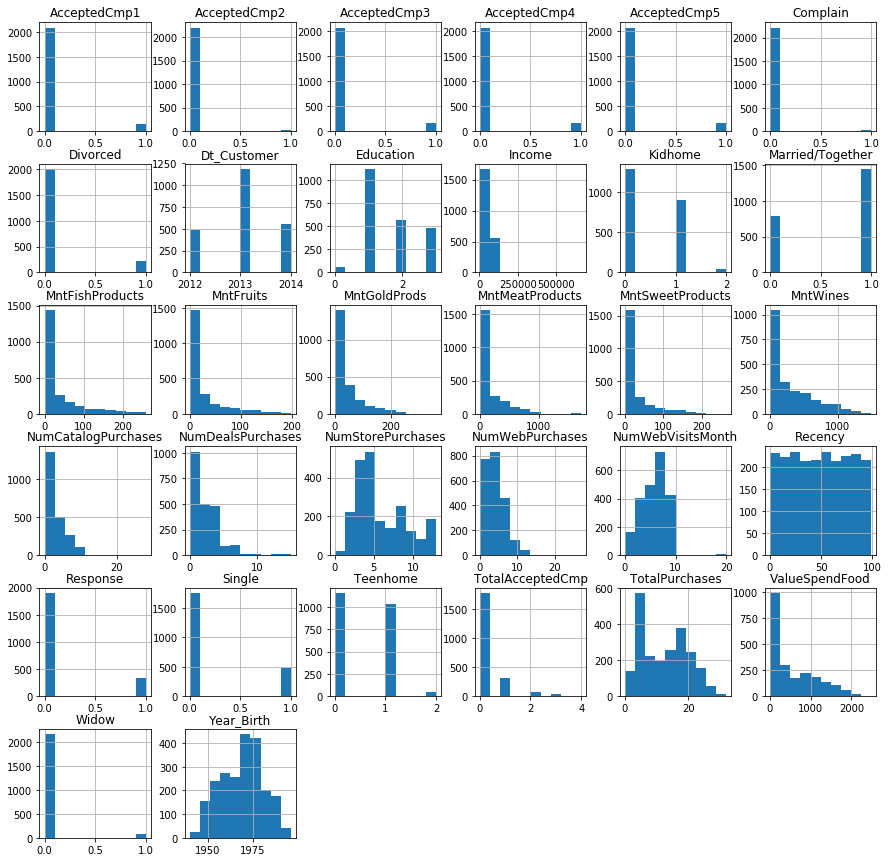

In [3848]:
_ = data_marketing_copy.hist(figsize=(15, 15))

#### Pearson Correlation 

- Correlation with target (Response):   
    * Correlations with target "Response": 
        - Higher Income higher probability to accept 
        - More teenagers at home, less probability to accept the campaign (This is the same to the others campaign too) 
        - Dt_Customer: Older clients have more probability to accept the campaign (-0.17 Year)
        - Recency: Clients that purchased something recently increase the probabability to accept the campaign 
        - MntWines and MnMeatProducts: Client that spend more with wine and meat has more probability to accept the campaign than the other products (Fruits, Fishs, Sweet)
        - Client that purchases in Catalogs and using web has more probability to accept campaign than the Stores Purchases
        - Accept the last campaing (AcceptedCmp5) has more probability to accept this actual campaign
        
        

In [3849]:
corr = data_marketing_copy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,ValueSpendFood,TotalPurchases,TotalAcceptedCmp,Divorced,Married/Together,Single,Widow
Year_Birth,1,-0.14,-0.16,0.24,-0.36,-0.023,-0.02,-0.16,-0.015,-0.03,-0.044,-0.02,-0.06,-0.068,-0.15,-0.13,-0.14,0.12,0.061,-0.064,0.012,-0.012,-0.0076,-0.0044,0.016,-0.11,-0.17,-0.0024,-0.068,-7.3e-05,0.12,-0.17
Education,-0.14,1,0.1,-0.039,0.1,0.039,-0.021,0.16,-0.087,0.0076,-0.091,-0.084,-0.12,0.026,0.067,0.058,0.067,-0.036,0.0099,0.041,0.015,-0.0063,0.019,-0.036,0.085,0.077,0.08,0.026,0.015,0.007,-0.036,0.038
Income,-0.16,0.1,1,-0.42,0.02,0.022,-0.0036,0.58,0.43,0.58,0.44,0.44,0.32,-0.082,0.38,0.59,0.53,-0.55,-0.016,0.18,0.33,0.27,0.088,-0.025,0.13,0.66,0.62,0.31,0.0094,0.0049,-0.027,0.032
Kidhome,0.24,-0.039,-0.42,1,-0.036,0.053,0.0065,-0.5,-0.37,-0.44,-0.39,-0.37,-0.35,0.22,-0.36,-0.5,-0.5,0.45,0.014,-0.16,-0.2,-0.17,-0.082,0.036,-0.079,-0.55,-0.57,-0.21,-0.021,0.022,0.023,-0.074
Teenhome,-0.36,0.1,0.02,-0.036,1,-0.0077,0.019,0.0055,-0.17,-0.26,-0.2,-0.16,-0.018,0.39,0.15,-0.11,0.051,0.13,-0.043,0.039,-0.19,-0.14,-0.016,0.0076,-0.16,-0.14,0.039,-0.13,0.054,0.031,-0.096,0.045
Dt_Customer,-0.023,0.039,0.022,0.053,-0.0077,1,-0.028,-0.15,-0.055,-0.084,-0.068,-0.073,-0.14,-0.19,-0.17,-0.085,-0.097,-0.25,0.011,-0.012,0.024,0.04,0.0008,-0.025,-0.17,-0.14,-0.14,0.023,-0.0056,0.005,0.0051,-0.015
Recency,-0.02,-0.021,-0.0036,0.0065,0.019,-0.028,1,0.017,-0.0047,0.023,0.00027,0.022,0.017,0.0011,-0.0091,0.024,0.0012,-0.02,-0.033,0.019,6.4e-05,-0.02,-0.0019,0.0053,-0.2,0.02,0.0069,-0.013,0.0015,-0.0056,0.0054,2.9e-06
MntWines,-0.16,0.16,0.58,-0.5,0.0055,-0.15,0.017,1,0.39,0.56,0.4,0.39,0.39,0.011,0.54,0.64,0.64,-0.32,0.062,0.37,0.47,0.35,0.21,-0.036,0.25,0.9,0.76,0.51,0.022,-0.0073,-0.024,0.037
MntFruits,-0.015,-0.087,0.43,-0.37,-0.17,-0.055,-0.0047,0.39,1,0.54,0.59,0.57,0.39,-0.13,0.3,0.49,0.46,-0.42,0.015,0.011,0.21,0.19,-0.0096,-0.0027,0.13,0.6,0.52,0.16,0.011,-0.025,0.0067,0.033
MntMeatProducts,-0.03,0.0076,0.58,-0.44,-0.26,-0.084,0.023,0.56,0.54,1,0.57,0.52,0.35,-0.12,0.29,0.72,0.48,-0.54,0.018,0.1,0.37,0.31,0.043,-0.021,0.24,0.85,0.62,0.31,-0.024,-0.021,0.034,0.019


#### BoxPlot

- There are many outliers in the data, exclude all theses rows will deacrease a lot the database. 
- The outliers have not innapropiate value that doesn't make senses

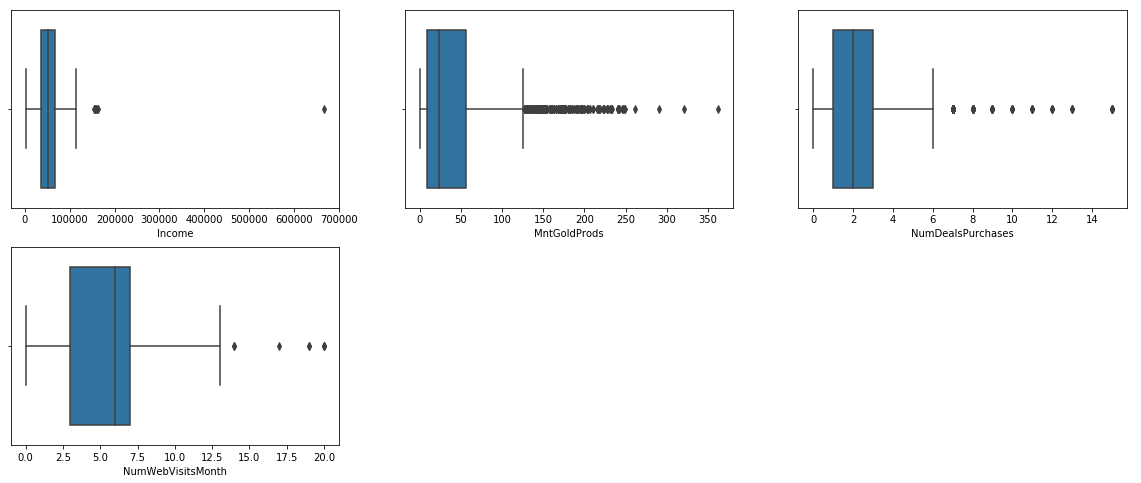

In [3850]:
boxplot_df = data_marketing_copy[columns_describe]

ncols = 3  # Numbers of columns to plot
nrows = int(np.ceil(len(boxplot_df.columns) / (1.0*ncols)))  # Calculate nrows based on numbers of features and ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8)) 

count = 0
for i in range(nrows):
    for j in range(ncols):
      
        # Plot when we have data
        if count < len(boxplot_df.columns):
            
            column = boxplot_df.columns[count]
            ax = sns.boxplot(ax=axes[i][j], x=boxplot_df[column])
            
        else:
            ax= axes[i][j]
            ax.set_axis_off()

        count += 1

plt.show()

#### Remove outliers

In [3851]:
columns_describe = ['Income', 'MntGoldProds', 'NumDealsPurchases','NumWebVisitsMonth']

data_marketing_copy[columns_describe].describe()

,Income,MntGoldProds,NumDealsPurchases,NumWebVisitsMonth
count,2233.000000,2233.000000,2233.000000,2233.000000
mean,52212.770264,43.827138,2.324675,5.320197
std,25057.339402,51.865500,1.932741,2.424492
min,1730.000000,0.000000,0.000000,0.000000
25%,35441.000000,9.000000,1.000000,3.000000
50%,51381.500000,24.000000,2.000000,6.000000
75%,68281.000000,56.000000,3.000000,7.000000
max,666666.000000,362.000000,15.000000,20.000000


#### IQR - Interquatile Range  

- It is a measure to see how is the spread degree in data
- It is used here to remove outliers 
- The function will just be used to compare results in the model ( With and Without Outliers)

In [3817]:
def remove_outliers(df):
    
    for column in columns_describe:

        Q1 = df[column].quantile(.25)
        Q3 = df[column].quantile(.75)

        IQR = Q3 - Q1 # Range between quartiles 

        upper = Q3 + IQR * 1.5
        lower = Q1 - IQR * 1.5

        return df[(df[column] <= upper) & (df[column] >= lower)]


### Visualization - Graphics 

In [3818]:
#g = sns.pairplot(data_marketing_copy[['Income', 'Education', 'Response', 'Preferable_food']], hue='Response')

#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)

#sns.catplot(x="TotalAcceptedCmp", y="Response", data=data_marketing_copy)

#data_marketing_copy.groupby(['Income', 'Education']).size()

#sns.histplot(data=data_marketing_copy, x="TotalAcceptedCmp", hue="Response")

#plot_bar(data_marketing_copy['TotalAcceptedCmp']


#Total = data_marketing_copy.groupby(['Response']).TotalAcceptedCmp.value_counts()
#p_Total = Total[1]/(Total[0] + Total[1])
#ax = pd.Series(p_Total).plot(marker="o", alpha=0.7)

#secax = ax.secondary_yaxis('right')

#import matplotlib.ticker as mtick


#secax.xaxis.set_minor_locator(0)
#secax.set_xlabel('$X_{other}$')

#plotbar = data_marketing_copy.groupby(['Response']).TotalAcceptedCmp.value_counts().unstack(0).plot.bar(colormap='YlOrBr', alpha=0.7, ax=ax, use_index=False)

#plt.show()


In [3819]:
def plot_bar(x, line_values, labelx, labely, title):
    
    sns.color_palette("YlOrBr", as_cmap=True)
    plt.figure(figsize=(15,8))
    
    # plot bar chart
    x.plot(kind="bar", alpha=0.7)
    
    # plot line chart
    pd.Series(line_values).plot(marker="o", alpha=0.7)
    
    plt.xlabel(labelx, fontsize="x-large")
    plt.ylabel(labely, fontsize="x-large")
    plt.title(title, fontsize="xx-large")
    
    plt.show()

In [3820]:
data_marketing_copy = data_marketing_copy.drop(columns=['BiggestExpensiveFood'])

#### Unbalanced data 

In [3821]:
data_marketing_copy.Response.value_counts()

0    1901
1     332
Name: Response, dtype: int64

In [3822]:
cluster_data = data_marketing_copy.drop(columns=['ValueSpendFood', 'TotalPurchases', 'TotalAcceptedCmp'])
cluster_data.columns

Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Divorced', 'Married/Together', 'Single',
       'Widow'],
      dtype='object')

In [3902]:
data_marketing_copy = data_marketing_copy[data_marketing_copy.Income < 666600]

In [3910]:
data_marketing_copy.columns
cluster_data = data_marketing_copy.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                                                 
                                                 'Divorced','Married/Together', 'Single',
                                                 'Widow', 'Complain', 'Response', 'BiggestExpensiveFood'])

In [3911]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2232 entries, 0 to 2239
Data columns (total 21 columns):
Year_Birth             2232 non-null int64
Education              2232 non-null int64
Income                 2232 non-null float64
Kidhome                2232 non-null int64
Teenhome               2232 non-null int64
Dt_Customer            2232 non-null int64
Recency                2232 non-null int64
MntWines               2232 non-null int64
MntFruits              2232 non-null int64
MntMeatProducts        2232 non-null int64
MntFishProducts        2232 non-null int64
MntSweetProducts       2232 non-null int64
MntGoldProds           2232 non-null int64
NumDealsPurchases      2232 non-null int64
NumWebPurchases        2232 non-null int64
NumCatalogPurchases    2232 non-null int64
NumStorePurchases      2232 non-null int64
NumWebVisitsMonth      2232 non-null int64
ValueSpendFood         2232 non-null int64
TotalPurchases         2232 non-null int64
TotalAcceptedCmp       2232 non

In [3912]:
transformer = RobustScaler().fit(cluster_data)

In [3913]:
cluster_data = pd.DataFrame(transformer.transform(cluster_data), columns=cluster_data.columns)

In [3914]:
len(cluster_data)

2232

### Clustering 

Choosing the best cluster quantity (based on WCSS and Silhouette Values)

- Silhouette: Higher values means more differences betweens clusters
- WCSS:

2232
2232
2232
2232
2232
2232
2232
2232


Text(0.5, 1.0, 'Silhouette')

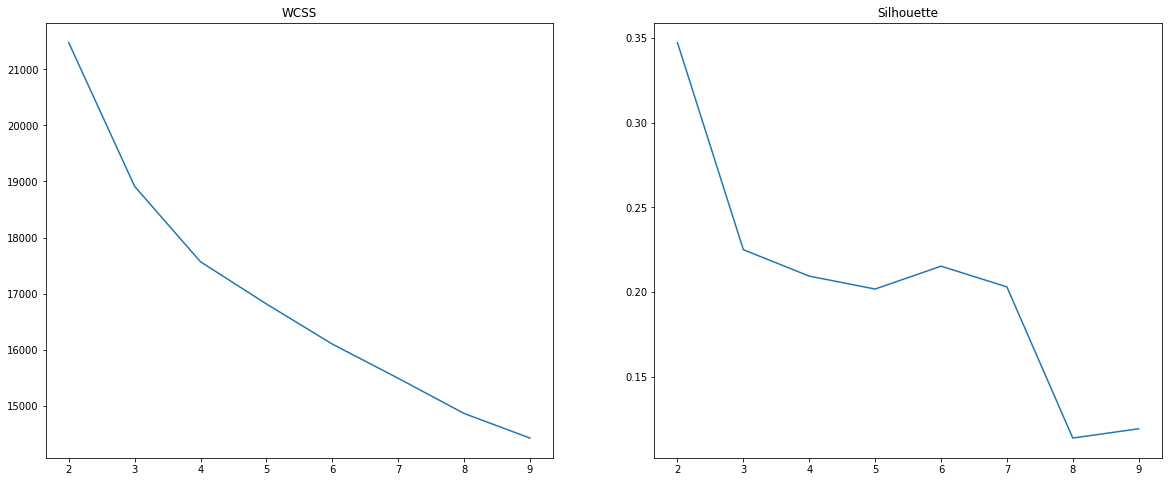

In [3915]:

#data_marketing_copy  = data_marketing_copy[data_marketing_copy.Income < 666666]
wcss = []
silhouette = []
qtd_clusters = range(2, 10)
for i in qtd_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=0)        
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    print(len(labels))
    silhouette.append(silhouette_score(cluster_data, labels, metric='euclidean'))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax_ = axes[0].plot(qtd_clusters, wcss)
axes[0].set_title("WCSS")
ax1_ = axes[1].plot(qtd_clusters, silhouette)
axes[1].set_title("Silhouette")

#### K-Means - 3 clusters 

In [3943]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, random_state=0)        
result = kmeans.fit_predict(cluster_data)

In [3944]:
len(kmeans.labels_)
print(len(cluster_data))
#kmeans.cluster_centers_

2232


In [3952]:
#colors = ['#4EACC5', '#FF9C34', '#4E9A06']

#for k, col in zip(range(n_clusters), colors):
    
    #center = k_means.cluster_centers_[k]
    
    #plt.scatter([y_kmeans==0, 0], X[y_kmeans==0, 1], s=100, c=col, label ='Cluster %'.format(k))
    #ax.plot(X[my_members, 0], X[my_members, 1], 'w',
    #        markerfacecolor=col, marker='.')
    #ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #        markeredgecolor='k', markersize=6)

In [3946]:
data_marketing_copy['Cluster'] = kmeans.labels_
#pd.concat([df, pd.DataFrame(kmeans.labels_, columns=['Cluster'])], axis=1)

In [3947]:
data_marketing_copy['Cluster'].value_counts()

1    1000
0     532
2     440
3     260
Name: Cluster, dtype: int64

In [3948]:
data_marketing_copy.groupby(['Cluster', 'Response']).size()

Cluster  Response
0        0           459
         1            73
1        0           915
         1            85
2        0           327
         1           113
3        0           199
         1            61
dtype: int64

In [3953]:
data_marketing_copy.groupby(['Cluster', 'Response']).size()[0].sum()

532

In [3951]:
print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[0][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[0].sum())
print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[1][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[1].sum())
print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[2][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[2].sum())
print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[3][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[3].sum())
#print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[4][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[4].sum())
#print(data_marketing_copy.groupby(['Cluster', 'Response']).size()[5][1]/data_marketing_copy.groupby(['Cluster', 'Response']).size()[5].sum())


0.13721804511278196
0.085
0.25681818181818183
0.23461538461538461


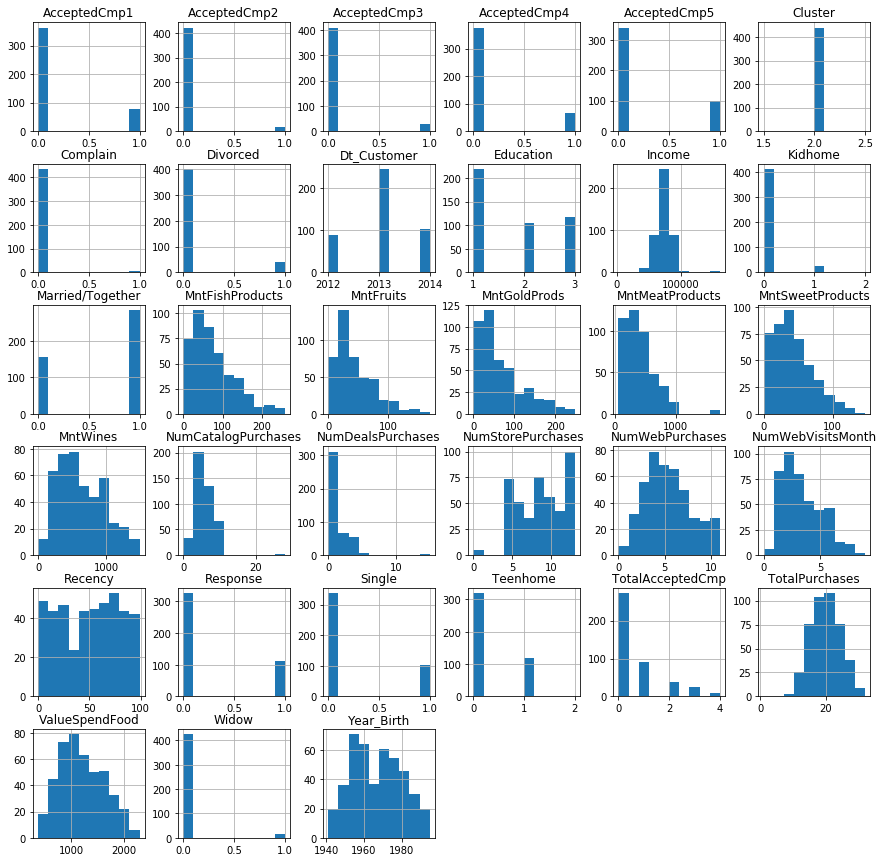

In [3954]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
_ = data_marketing_copy[data_marketing_copy['Cluster'] == 2].hist(figsize=(15, 15))

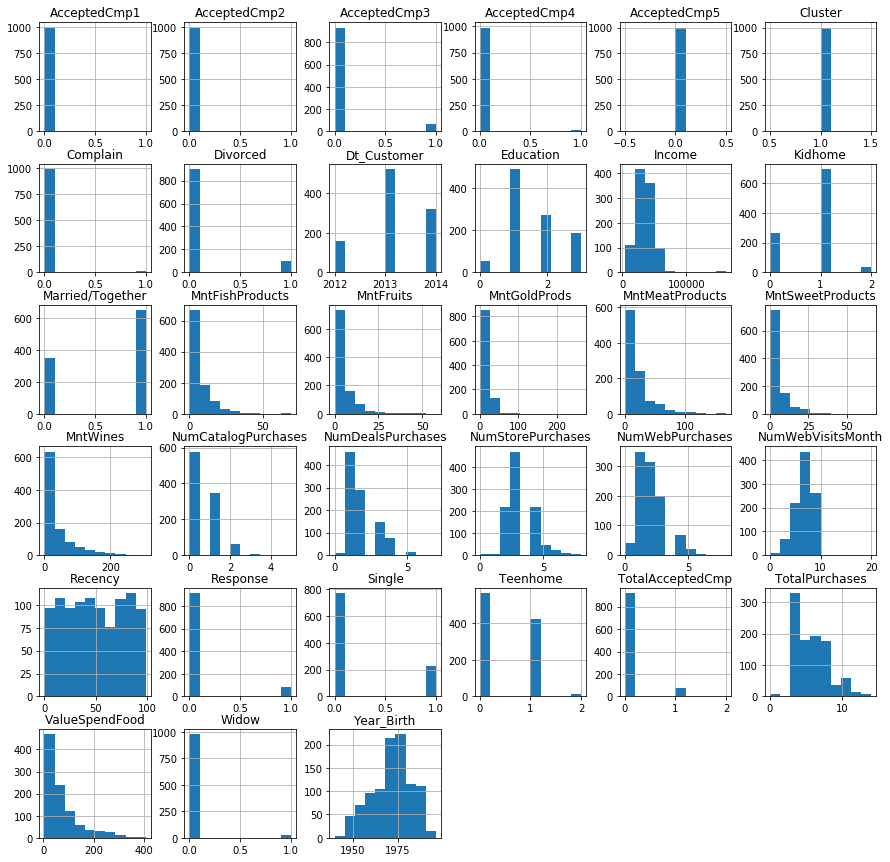

In [3955]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
_ = data_marketing_copy[data_marketing_copy['Cluster'] == 1].hist(figsize=(15, 15))

In [3736]:
data_marketing_copy.describe()

,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,ValueSpendFood,TotalPurchases,TotalAcceptedCmp,Divorced,Married/Together,Single,Widow,Cluster
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,1968.888889,1.663978,51937.477599,0.444892,0.506720,2013.028674,49.154122,304.065412,26.244624,166.957885,37.415771,27.099014,43.841398,2.323925,4.085573,2.660394,5.794803,5.319892,0.073029,0.074821,0.072133,0.064068,0.013441,0.008961,0.148746,561.782706,12.540771,0.297491,0.103495,0.646057,0.215950,0.034498,2.936828
std,11.699288,0.839410,21420.681136,0.538613,0.544686,0.684124,28.949677,336.871724,39.711783,225.752900,54.456115,41.320001,51.872745,1.932849,2.781015,2.921548,3.253934,2.424993,0.260242,0.263161,0.258765,0.244929,0.115179,0.094256,0.355917,576.716193,7.210614,0.678301,0.304672,0.478299,0.411572,0.182546,1.495562
min,1940.000000,0.000000,1730.000000,0.000000,0.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,1.000000,35434.750000,0.000000,0.000000,2013.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1970.000000,1.000000,51381.500000,0.000000,0.000000,2013.000000,49.500000,173.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,341.000000,12.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
75%,1977.000000,2.000000,68275.750000,1.000000,1.000000,2013.000000,74.000000,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,962.500000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000
max,1996.000000,3.000000,162397.000000,2.000000,2.000000,2014.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2491.000000,32.000000,4.000000,1.000000,1.000000,1.000000,1.000000,5.000000


#### Divide train and test data

In [3451]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [3452]:
print(y_test.value_counts())
random_base = RandomOverSampler(random_state=0)
X_balanced, y_balanced = random_base.fit_resample(X_train, y_train)

0    576
1     94
Name: Response, dtype: int64


In [3453]:
def test_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train,y_train, verbose=True)
    
    preds = model.predict(X_test)
    
    # Metrics
    print(accuracy_score(preds, y_test))
    print(recall_score(preds, y_test, average="macro"))
    print(f1_score(preds, y_test))

#### XGBoost

In [3454]:
xg_class = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=6, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, use_label_encoder=False)

In [3455]:
test_model(xg_class, X_balanced, y_balanced, X_test, y_test)

[21:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8940298507462686
0.7788111851606954
0.6358974358974359


In [3456]:
param_test1 = {
  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.3, n_estimators=140, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4, cv=5)
gsearch1.fit(X_balanced,y_balanced)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\asus.PC\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=9, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [3458]:

gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### Confusion-Matrix

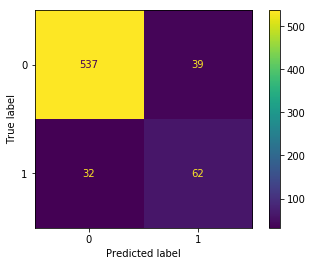

In [3459]:
plot_confusion_matrix(xg_class, X_test, y_test)

In [3413]:
xg_reg.feature_importances_

array([0.02659003, 0.02291145, 0.02886571, 0.0256041 , 0.03787005,
       0.10407633, 0.04709913, 0.02015557, 0.01532386, 0.02605063,
       0.01667872, 0.02000649, 0.02102163, 0.02010923, 0.01837825,
       0.04201874, 0.02069903, 0.02372277, 0.01830761, 0.03347398,
       0.01249165, 0.00828688, 0.02898823, 0.01371554, 0.22378604,
       0.0108375 , 0.03669926, 0.02311799, 0.05311361], dtype=float32)

In [3414]:
X.columns

Index(['Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'ValueSpendFood', 'TotalPurchases', 'TotalAcceptedCmp',
       'Divorced', 'Married/Together', 'Single', 'Widow'],
      dtype='object')